# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================
import pandas as pd
import json
import random
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.data import path_loader, create_dataset
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-06-05 20:18:39.199284: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-05 20:18:39.230432: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 20:18:40.329910: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 20:18:40.333655: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"] = 100
TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-06-05 20:18:41.086156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


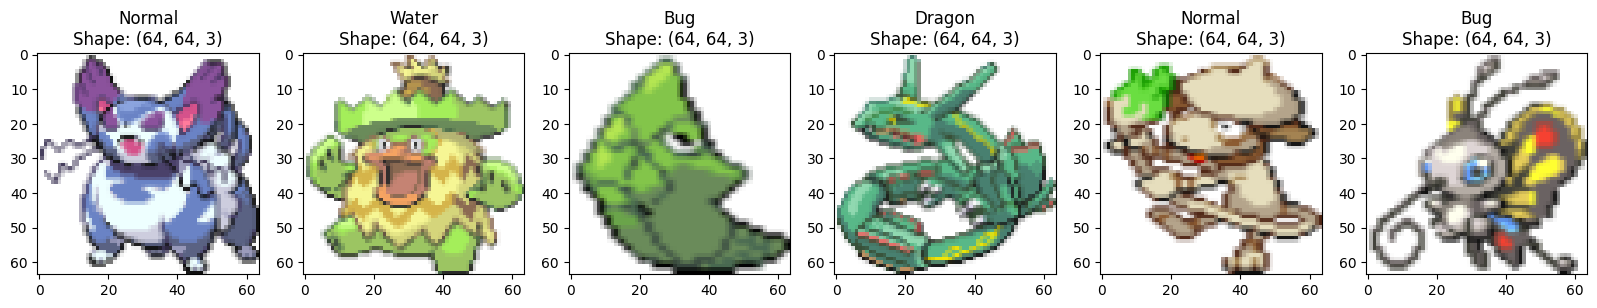

2024-06-05 20:18:42.467838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 64, 64, 3)
(32, 18)


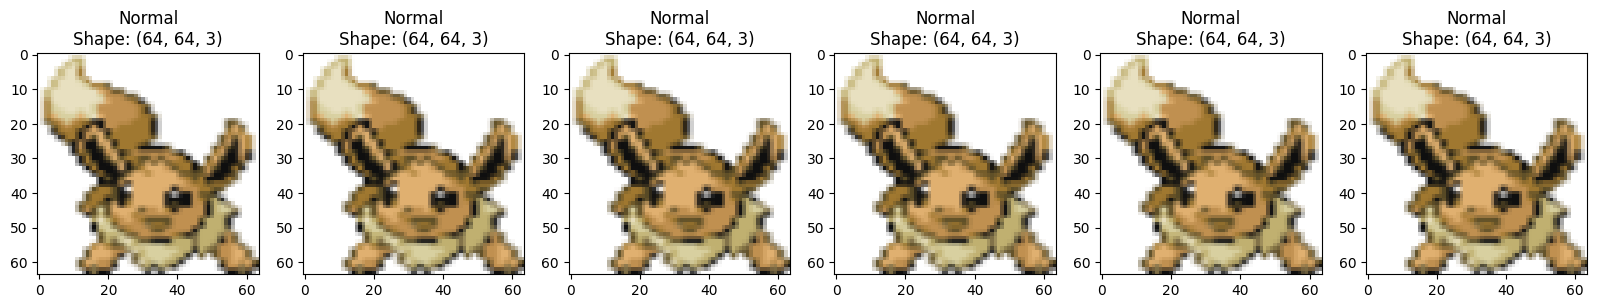

2024-06-05 20:18:42.879053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-05 20:18:42.879848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# expand the items to the batch size
img_example = np.expand_dims(img_example, axis=0)
label_example = np.expand_dims(label_example, axis=0)

dataset_overfitting = tf.data.Dataset.from_tensor_slices((img_example, label_example))

n_images = len(poke_dataset) * BATCH_SIZE
dataset_overfitting = dataset_overfitting.repeat(n_images).batch(BATCH_SIZE)

for img, label in dataset_overfitting:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_overfitting.take(1):
    label_example = label[0]
    visualize.plot_images_batch(dataset_tf=dataset_overfitting)

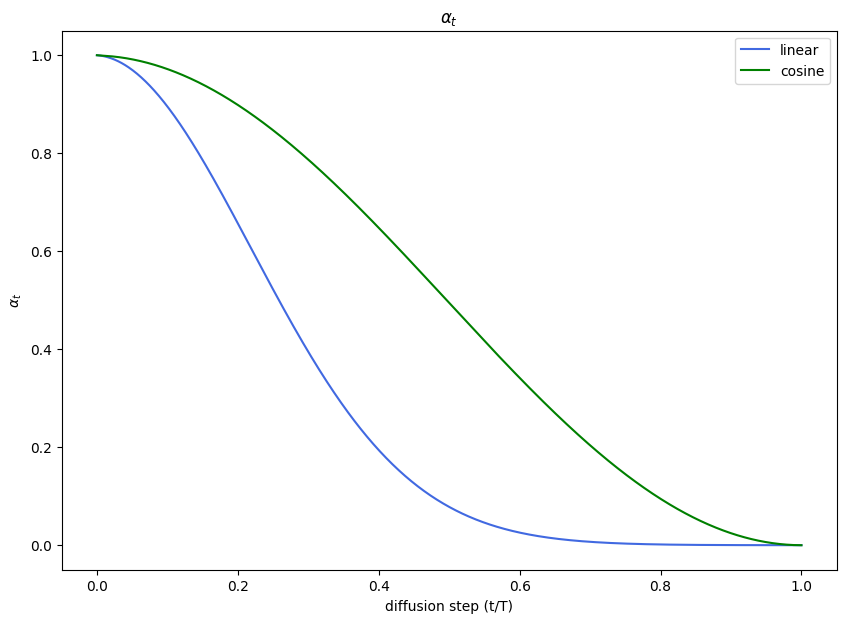

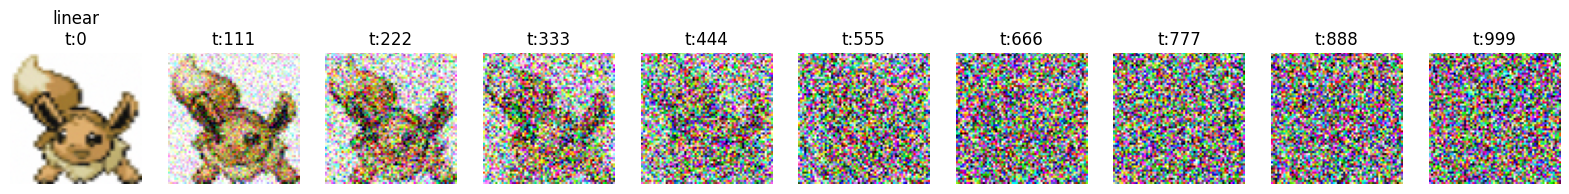

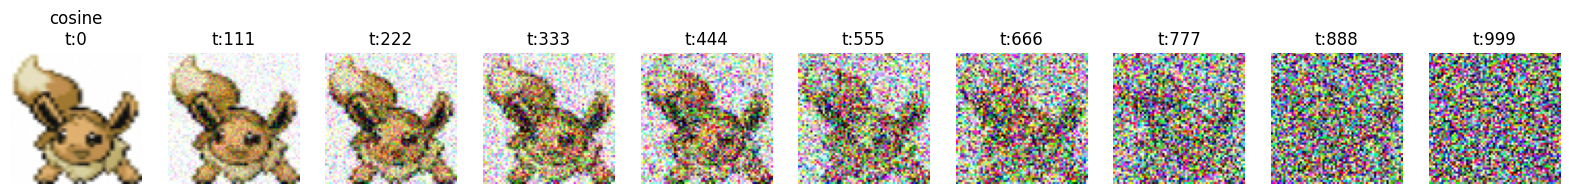

In [6]:
# Plot all the noise levels in the same plot
# =====================================================================
visualize.plot_noise_levels(TIMESTEPS, BETA_START, BETA_END, S)

# Plot the forward diffusion function
# =====================================================================
X_train = dataset_overfitting.map(lambda x, y: x)  # Get the images from the dataset
random_image = next(iter(X_train))[random.randint(0, BATCH_SIZE)]

visualize.plot_forward_diffusion(
    random_image, "linear", 10, TIMESTEPS, BETA_START, BETA_END, S
)
visualize.plot_forward_diffusion(
    random_image, "cosine", 10, TIMESTEPS, BETA_START, BETA_END, S
)

In [7]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

Epoch 1/100


I0000 00:00:1717618739.643013   33443 service.cc:145] XLA service 0x7e2638001b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717618739.643040   33443 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-05 20:19:00.063809: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1717618740.556703   33443 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
2024-06-05 20:19:01.532880: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1717618742.788111   33985 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 8 bytes

  1/127 ━━━━━━━━━━━━━━━━━━━━ 1:13:46 35s/step - mae: 1.2034 - loss: 2.2913

I0000 00:00:1717618762.691140   33443 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/127 ━━━━━━━━━━━━━━━━━━━━ 55s 154ms/step - mae: 0.7561 - loss: 0.9631
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.3715 - loss: 0.2498
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.2981 - loss: 0.1684
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.2680 - loss: 0.1387
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.2452 - loss: 0.1175
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.2305 - loss: 0.1051
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.2206 - loss: 0.0990
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.2089 - loss: 0.0879
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.2000 - loss: 0.0829
Epoch 10/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1910 - loss: 0.0761
Epoch 11/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1853 - loss: 0.0727
Epoch 12/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1873 - lo

Sampling sprite...: 100%|██████████| 999/999 [01:30<00:00, 11.05it/s]


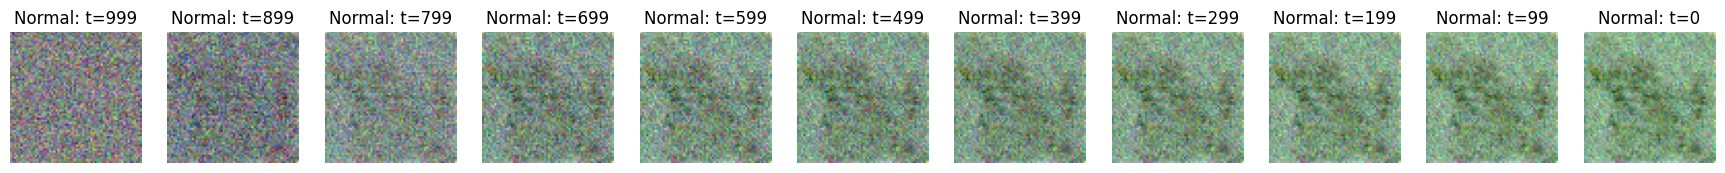

127/127 ━━━━━━━━━━━━━━━━━━━━ 111s 879ms/step - mae: 0.1504 - loss: 0.0533
Epoch 21/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.1461 - loss: 0.0510
Epoch 22/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1323 - loss: 0.0431
Epoch 23/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.1299 - loss: 0.0427
Epoch 24/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1198 - loss: 0.0361
Epoch 25/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1157 - loss: 0.0331
Epoch 26/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1076 - loss: 0.0288
Epoch 27/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1034 - loss: 0.0277
Epoch 28/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0968 - loss: 0.0235
Epoch 29/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1036 - loss: 0.0288
Epoch 30/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.1523 - loss: 0.0536
Epoch 31/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.

Sampling sprite...: 100%|██████████| 999/999 [01:30<00:00, 10.99it/s]


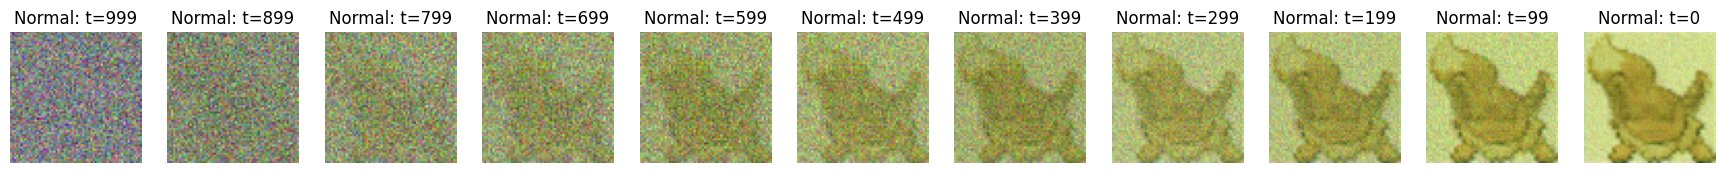

127/127 ━━━━━━━━━━━━━━━━━━━━ 111s 883ms/step - mae: 0.0838 - loss: 0.0169
Epoch 41/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0790 - loss: 0.0151
Epoch 42/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0788 - loss: 0.0152
Epoch 43/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0772 - loss: 0.0146
Epoch 44/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0730 - loss: 0.0125
Epoch 45/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0714 - loss: 0.0126
Epoch 46/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0755 - loss: 0.0147
Epoch 47/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0681 - loss: 0.0112
Epoch 48/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0705 - loss: 0.0117
Epoch 49/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - mae: 0.0771 - loss: 0.0153
Epoch 50/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - mae: 0.0655 - loss: 0.0104
Epoch 51/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - mae: 0.

Sampling sprite...: 100%|██████████| 999/999 [01:29<00:00, 11.10it/s]


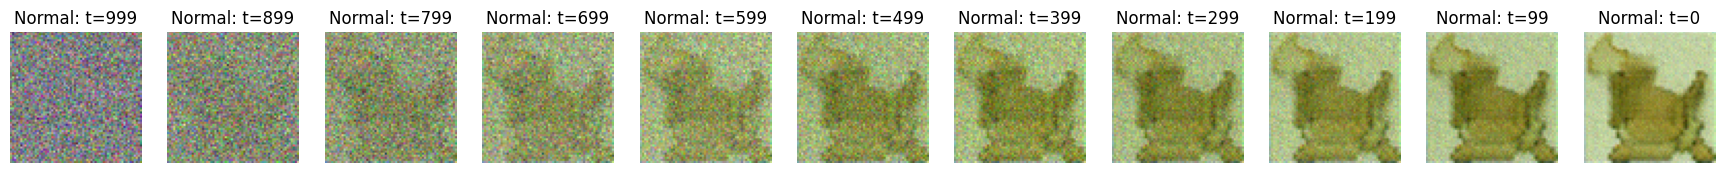

127/127 ━━━━━━━━━━━━━━━━━━━━ 111s 878ms/step - mae: 0.0540 - loss: 0.0069
Epoch 61/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - mae: 0.0563 - loss: 0.0080
Epoch 62/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0555 - loss: 0.0076
Epoch 63/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0549 - loss: 0.0072
Epoch 64/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0559 - loss: 0.0075
Epoch 65/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0565 - loss: 0.0079
Epoch 66/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0564 - loss: 0.0079
Epoch 67/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0544 - loss: 0.0072
Epoch 68/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0689 - loss: 0.0130
Epoch 69/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0537 - loss: 0.0071
Epoch 70/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0530 - loss: 0.0072
Epoch 71/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.

Sampling sprite...: 100%|██████████| 999/999 [01:30<00:00, 11.00it/s]


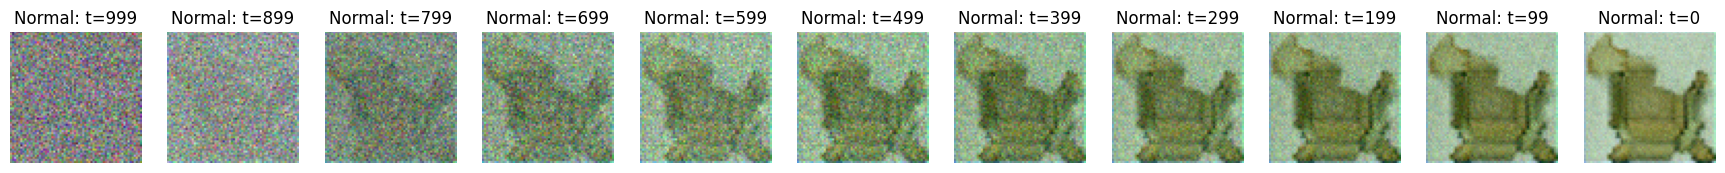

127/127 ━━━━━━━━━━━━━━━━━━━━ 111s 882ms/step - mae: 0.0557 - loss: 0.0083
Epoch 81/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0446 - loss: 0.0046
Epoch 82/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - mae: 0.0501 - loss: 0.0067
Epoch 83/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0459 - loss: 0.0055
Epoch 84/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0507 - loss: 0.0065
Epoch 85/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0523 - loss: 0.0070
Epoch 86/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0444 - loss: 0.0047
Epoch 87/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0505 - loss: 0.0070
Epoch 88/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0450 - loss: 0.0050
Epoch 89/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - mae: 0.0454 - loss: 0.0054
Epoch 90/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.0517 - loss: 0.0071
Epoch 91/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - mae: 0.

Sampling sprite...: 100%|██████████| 999/999 [01:31<00:00, 10.95it/s]


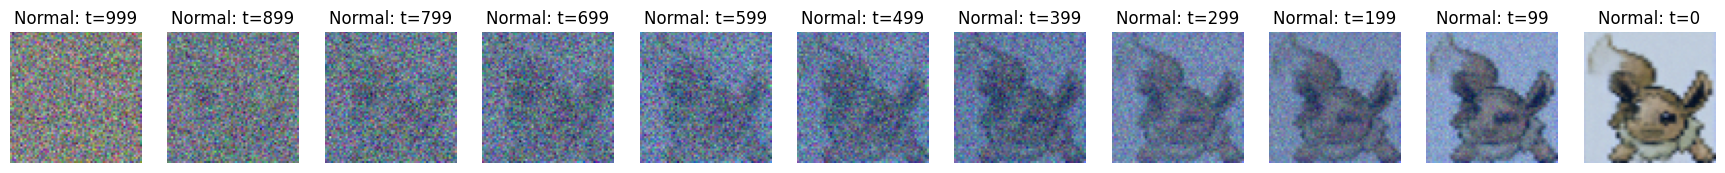

127/127 ━━━━━━━━━━━━━━━━━━━━ 112s 886ms/step - mae: 0.0507 - loss: 0.0065


In [8]:
diff_callback = DiffusionCallback(model, 20, onehot_to_string(label_example))
model.fit(dataset_overfitting, epochs=EPOCHS, callbacks=[diff_callback])

Generating sample 1/6


Sampling sprite...: 100%|██████████| 999/999 [01:29<00:00, 11.21it/s]


Generating sample 2/6


Sampling sprite...: 100%|██████████| 999/999 [01:28<00:00, 11.29it/s]


Generating sample 3/6


Sampling sprite...: 100%|██████████| 999/999 [01:29<00:00, 11.18it/s]


Generating sample 4/6


Sampling sprite...: 100%|██████████| 999/999 [01:28<00:00, 11.35it/s]


Generating sample 5/6


Sampling sprite...: 100%|██████████| 999/999 [01:28<00:00, 11.24it/s]


Generating sample 6/6


Sampling sprite...: 100%|██████████| 999/999 [01:28<00:00, 11.28it/s]


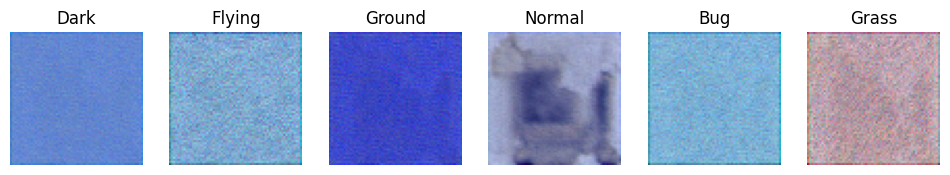

In [9]:
model.plot_samples(6)